In [1]:
import logging
logging.basicConfig(
    level=logging.INFO,
    handlers=[logging.FileHandler(filename='Risultati2.log')])
loggerTotali = logging.getLogger('Dataset_totali')

In [2]:
import pandas as pd
dataset = pd.read_excel('IncidentiModificato.xlsx', sheet_name='Foglio1', index_col=0)
dataset.head()

,DATA,SESSO,ANNI,PESO,ALTEZZA,BMI,Mezzo,Testa:Neurocranio,Testa:Splancnocranio,Testa:Telencefalo,...,Scheletro:Rachide-cervicale,Scheletro:Rachide-toracico,Scheletro:Rachide-lombare,Scheletro:Bacino-e-sacro,Scheletro:Complesso-sterno/claveo/costale,Tot Testa,Tot Torace,Tot Addome,Tot Scheletro,Totale
VERBALE,,,,,,,,,,,,,,,,,,,,,
85567,1999-10-29,0,81,84.0,1.75,27.428571,0,1,0,0,...,0,3,0,3,3,2,0,3,9,14
85829,2000-01-14,1,69,69.0,1.62,26.291724,1,4,4,4,...,0,0,0,0,4,20,7,1,4,32
85977,2000-03-10,1,71,67.0,1.55,27.887617,1,2,0,1,...,0,0,0,0,4,6,0,0,4,10
86220,2000-06-14,1,54,60.0,1.59,23.733238,1,4,0,0,...,0,0,0,0,4,5,3,2,4,14
86247,2000-06-22,1,78,69.0,1.67,24.740937,1,2,0,0,...,0,0,0,0,4,2,0,2,4,8


In [3]:
len(dataset)

130

In [4]:
dataset.index.unique()

Index([    85567,     85829,     85977,     86220,     86247,     86421,
           86839,     86876,     86878,     90056,
       ...
          101097,    101180,    101189,    101544,    101583,    101618,
       '101288E', 'E-97586',       'X',      'X1'],
      dtype='object', name='VERBALE', length=130)

In [5]:
def checkDataset(dataset):
    #controllo che i verbali siano valori unici
    if (len(dataset.index) != len(dataset.index.unique())):
        raise Exception('I verbali non possono essere usati come indice')

    #controllo i valori degli anni
    anni = dataset['ANNI']
    for anno in anni:
        if anno < 1 or anno > 95:
            raise Exception(f'Anno inserito non valido {anno}')
    
    #controllo i valori dei pesi
    pesi = dataset['PESO']
    for peso in pesi:
        if peso < 30 or peso > 120:
            raise Exception(f'Peso inserito non valido {peso}')
    
    #controllo i valori dell'altezza
    altezze = dataset['ALTEZZA']
    for altezza in altezze:
        if altezza < 1.00 or altezza > 2.10:
            raise Exception(f'Altezza inserito non valida {altezza}')
    
    #controllo del BMI
    valori_BMI = dataset['BMI']
    for bmi in valori_BMI:
        if bmi < 10.0 or bmi > 50.0:
            raise Exception(f'bmi inserito non valido {bmi}')
            
    #controllo altri valori compresi tra 0 e 4
    dataset_valori_0_4 = dataset['Testa:Neurocranio']
    for valore in dataset_valori_0_4:
        if valore < 0 or valore > 4:
            raise Exception(f'{valore} non compresa tra 0 e 4')
            

    print("Valori del dataset corretti")
    

checkDataset(dataset)

Valori del dataset corretti


In [6]:
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV, cross_val_score
import time
from random import seed
import numpy as np


def addestra(model_class, X, y, model_selection_grid, num_fold_grid_search, num_fold_cross_val, scaling=StandardScaler(), dim_reduction=None):
    
    start_time = time.time()
    
    X_std = scaling.fit_transform(X) if scaling is not None else X
    
    X_std = dim_reduction.fit_transform(X_std) if dim_reduction is not None else X_std
    np.random.seed(42)
    clf = GridSearchCV(estimator=model_class(), param_grid=model_selection_grid, cv=num_fold_grid_search, iid=True, n_jobs=-1)
    val = cross_val_score(clf, X_std, y, cv=num_fold_cross_val)
    print("--- %s seconds ---" % (time.time() - start_time))
    return val


## Iniziamo considerando solo i totali per distretto

In [7]:
X_total = dataset[['SESSO', 'ANNI', 'PESO', 'ALTEZZA', 'Tot Testa', 'Tot Torace', 'Tot Addome', 'Tot Scheletro']]
y_total = dataset['Mezzo']

In [8]:
risultati = {}

In [9]:
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neural_network import MLPClassifier

models = [SVC, DecisionTreeClassifier, RandomForestClassifier, GaussianNB, LinearDiscriminantAnalysis, MLPClassifier]
model_to_string = {SVC: 'SVC', DecisionTreeClassifier: 'DT', RandomForestClassifier:'RF', GaussianNB: 'NB', LinearDiscriminantAnalysis: 'LD', MLPClassifier: 'MLP'}

c_space = np.logspace(-4, 3, 10)
gamma_space = np.logspace(-4, 3, 10)

model_selection_grid_SVC = [
  {'C': c_space, 'kernel': ['linear'], 'gamma': ['auto']},
  {'C': c_space, 'gamma': gamma_space, 'kernel': ['rbf']},
  {'C': c_space, 'gamma': ['auto', 'scale'], 'kernel': ['rbf']},
  {'C': c_space, 'degree': [2, 3, 5, 9], 'kernel': ['poly'], 'gamma': ['auto']},
 ]

model_selection_grid_DT = {'criterion': ['gini', 'entropy'],
                        'max_leaf_nodes': [None, 2, 5, 10, 50, 100],
                        'max_features': [None, 'sqrt', 'log2'],
                        'max_depth': [None, 2, 5, 10]}



model_selection_grid_RF = {'n_estimators': [5, 10, 50, 100, 200],
                        'criterion': ['gini', 'entropy'],
                        'max_leaf_nodes': [None, 2, 5, 10, 50, 100],
                        'max_features': [None, 'sqrt', 'log2'],
                        'max_depth': [None, 2, 5, 10]}

model_selection_grid_NB = {}
model_selection_grid_LD = {}

model_selection_grid_MLP = {'max_iter': [5000],
                        'hidden_layer_sizes': [[2], [4], [6], [10], [20], [4, 4], [10, 10]],
                        'activation': ['identity', 'logistic', 'tanh', 'relu']}

grids = [model_selection_grid_SVC, model_selection_grid_DT, model_selection_grid_RF, model_selection_grid_NB, model_selection_grid_LD, model_selection_grid_MLP]

In [10]:
risultati['Totali'] = {model_to_string[m]: np.mean(addestra(m, X_total, y_total, g, 9, 9)) for m, g in zip(models, grids)}
loggerTotali.info(risultati['Totali'])

--- 32.94188141822815 seconds ---
--- 5.923735857009888 seconds ---
--- 1660.9387757778168 seconds ---
--- 0.1752948760986328 seconds ---
--- 0.24924731254577637 seconds ---
--- 318.83595633506775 seconds ---


In [11]:
table = pd.DataFrame(risultati)
table

,Totali
DT,0.560317
LD,0.719210
MLP,0.674155
NB,0.706064
RF,0.622914
SVC,0.666748


# Proviamo considerando anche il BMI

In [12]:
X_total_with_BMI = dataset[['SESSO', 'ANNI', 'PESO', 'ALTEZZA', 'BMI', 'Tot Testa', 'Tot Torace', 'Tot Addome', 'Tot Scheletro']]
y_total_with_BMI = dataset['Mezzo']

In [13]:
risultati['Totali_with_BMI'] = {model_to_string[m]: np.mean(addestra(m, X_total_with_BMI, y_total_with_BMI, g, 9, 9)) for m, g in zip(models, grids)}
loggerTotali.info(risultati['Totali_with_BMI'])

--- 37.97696280479431 seconds ---
--- 6.640751123428345 seconds ---
--- 1676.4074397087097 seconds ---
--- 0.1735391616821289 seconds ---
--- 0.21575140953063965 seconds ---
--- 330.29100370407104 seconds ---


In [14]:
table = pd.DataFrame(risultati)
table

,Totali,Totali_with_BMI
SVC,0.666748,0.666748
DT,0.560317,0.568254
RF,0.622914,0.592755
NB,0.706064,0.690110
LD,0.719210,0.704925
MLP,0.674155,0.666748


# Usiamo la DATA senza BMI

In [15]:
date_ordinate = dataset['DATA'].sort_values()
prima_data = date_ordinate.values[0]
print("La prima data del dataset è: ", prima_data)

La prima data del dataset è:  1999-10-29T00:00:00.000000000


In [16]:
import datetime as dt

dataset.DATA = dataset.DATA.apply(lambda d: (d - dt.datetime(1970,1,1)).days)

dataset.head()

,DATA,SESSO,ANNI,PESO,ALTEZZA,BMI,Mezzo,Testa:Neurocranio,Testa:Splancnocranio,Testa:Telencefalo,...,Scheletro:Rachide-cervicale,Scheletro:Rachide-toracico,Scheletro:Rachide-lombare,Scheletro:Bacino-e-sacro,Scheletro:Complesso-sterno/claveo/costale,Tot Testa,Tot Torace,Tot Addome,Tot Scheletro,Totale
VERBALE,,,,,,,,,,,,,,,,,,,,,
85567,10893,0,81,84.0,1.75,27.428571,0,1,0,0,...,0,3,0,3,3,2,0,3,9,14
85829,10970,1,69,69.0,1.62,26.291724,1,4,4,4,...,0,0,0,0,4,20,7,1,4,32
85977,11026,1,71,67.0,1.55,27.887617,1,2,0,1,...,0,0,0,0,4,6,0,0,4,10
86220,11122,1,54,60.0,1.59,23.733238,1,4,0,0,...,0,0,0,0,4,5,3,2,4,14
86247,11130,1,78,69.0,1.67,24.740937,1,2,0,0,...,0,0,0,0,4,2,0,2,4,8


In [17]:
X_total_with_data = dataset[['DATA', 'SESSO', 'ANNI', 'PESO', 'ALTEZZA', 'Tot Testa', 'Tot Torace', 'Tot Addome', 'Tot Scheletro']]
y_total_with_data = dataset['Mezzo']

In [18]:
risultati['Totali_with_data'] = {model_to_string[m]: np.mean(addestra(m, X_total_with_data, y_total_with_data, g, 9, 9)) for m, g in zip(models, grids)}
loggerTotali.info(risultati['Totali_with_data'])

--- 37.45645833015442 seconds ---
--- 6.441876649856567 seconds ---
--- 1659.681710243225 seconds ---
--- 0.19018173217773438 seconds ---
--- 0.222672700881958 seconds ---
--- 337.8771984577179 seconds ---


In [19]:
table = pd.DataFrame(risultati)
table

,Totali,Totali_with_BMI,Totali_with_data
SVC,0.666748,0.666748,0.771591
DT,0.560317,0.568254,0.608018
RF,0.622914,0.592755,0.631013
NB,0.706064,0.690110,0.727147
LD,0.719210,0.704925,0.718071
MLP,0.674155,0.666748,0.727147


# Usiamo ora sia il bmi che la data

In [20]:
X_total_with_data_and_BMI = dataset[['DATA', 'SESSO', 'ANNI', 'PESO', 'ALTEZZA', 'BMI', 'Tot Testa', 'Tot Torace', 'Tot Addome', 'Tot Scheletro']]
y_total_with_data_and_BMI = dataset['Mezzo']

In [21]:
risultati['Totali_with_date_and_bmi'] = {model_to_string[m]: np.mean(addestra(m, X_total_with_data_and_BMI, y_total_with_data_and_BMI, g, 9, 9)) for m, g in zip(models, grids)}
loggerTotali.info(risultati['Totali_with_date_and_bmi'])

--- 43.46218419075012 seconds ---
--- 6.598410129547119 seconds ---
--- 1671.5151841640472 seconds ---
--- 0.20122337341308594 seconds ---
--- 0.21996474266052246 seconds ---
--- 361.5102508068085 seconds ---


In [22]:
table = pd.DataFrame(risultati)
table

,Totali,Totali_with_BMI,Totali_with_data,Totali_with_date_and_bmi
SVC,0.666748,0.666748,0.771591,0.757916
DT,0.560317,0.568254,0.608018,0.637648
RF,0.622914,0.592755,0.631013,0.644607
NB,0.706064,0.690110,0.727147,0.749369
LD,0.719210,0.704925,0.718071,0.711803
MLP,0.674155,0.666748,0.727147,0.726618


## Aumentiamo la precisione, scendendo nei cinque livelli di ogni distretto

In [23]:
selected_cols = ['Testa:Neurocranio',
                 'Testa:Splancnocranio',
                 'Testa:Telencefalo',
                 'Testa:Cervelletto',
                 'Testa:Tronco-encefalico',
                 'Torace:Polmoni',
                 'Torace:Trachea/bronchi',
                 'Torace:Cuore',
                 'Torace:Aorta-toracica',
                 'Torace:Diaframma',
                 'Addome:Fegato',
                 'Addome:Milza',
                 'Addome:Aorta-addominale',
                 'Addome:Reni',
                 'Addome:Mesentere',
                 'Scheletro:Rachide-cervicale',
                 'Scheletro:Rachide-toracico',
                 'Scheletro:Rachide-lombare',
                 'Scheletro:Bacino-e-sacro',
                 'Scheletro:Complesso-sterno/claveo/costale']

X_details = dataset[selected_cols]
y_details = dataset['Mezzo']

Iniziamo facendo un controllo su quanto sia possibile ridurre la dimensione dei dati

In [24]:
pca = PCA(n_components = 20)
pca.fit(X_details)

PCA(copy=True, iterated_power='auto', n_components=20, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

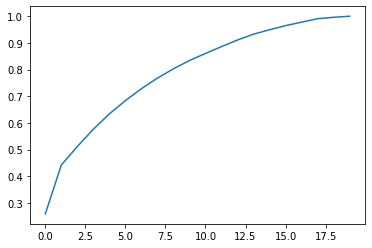

In [25]:
%matplotlib inline

from matplotlib import pyplot as plt

plt.plot(range(20), pca.explained_variance_ratio_.cumsum())
plt.show()

In [26]:
pca.explained_variance_ratio_.cumsum()

array([0.2590028 , 0.4424267 , 0.51161017, 0.57652743, 0.63390248,
       0.68359398, 0.72846105, 0.7680911 , 0.80302776, 0.83411104,
       0.8604245 , 0.88623497, 0.91098428, 0.9328969 , 0.94926481,
       0.96485529, 0.97790404, 0.99078593, 0.99608975, 1.        ])

In [27]:
pca.explained_variance_ratio_.cumsum()[12]

0.9109842843806883

Scendendo quindi da 20 a 13 feature si mantiene più del 90% della varianza

### Iniziamo comunque con tutte le 20 feature

In [28]:
risultati['Details'] = {model_to_string[m]: np.mean(addestra(m, X_details, y_details, g, 9, 9)) for m, g in zip(models, grids)}

--- 98.31639504432678 seconds ---
--- 6.2603466510772705 seconds ---
--- 1642.868482351303 seconds ---
--- 0.18396282196044922 seconds ---
--- 0.22692084312438965 seconds ---
--- 371.0937023162842 seconds ---


In [29]:
table = pd.DataFrame(risultati)
table

,Totali,Totali_with_BMI,Totali_with_data,Totali_with_date_and_bmi,Details
SVC,0.666748,0.666748,0.771591,0.757916,0.670330
DT,0.560317,0.568254,0.608018,0.637648,0.628653
RF,0.622914,0.592755,0.631013,0.644607,0.632601
NB,0.706064,0.690110,0.727147,0.749369,0.635979
LD,0.719210,0.704925,0.718071,0.711803,0.643386
MLP,0.674155,0.666748,0.727147,0.726618,0.600692


### Scendiamo a 13 feature con PCA

In [30]:
risultati['Details_reduce_PCA'] = {model_to_string[m]: np.mean(addestra(m, X_details, y_details, g, 9, 9, dim_reduction=PCA(n_components=13))) for m, g in zip(models, grids)}

--- 66.28899836540222 seconds ---
--- 6.964657545089722 seconds ---
--- 1741.5210511684418 seconds ---
--- 0.2050647735595703 seconds ---
--- 0.23760175704956055 seconds ---
--- 365.70172214508057 seconds ---


In [31]:
table = pd.DataFrame(risultati)
table

,Totali,Totali_with_BMI,Totali_with_data,Totali_with_date_and_bmi,Details,Details_reduce_PCA
SVC,0.666748,0.666748,0.771591,0.757916,0.670330,0.670248
DT,0.560317,0.568254,0.608018,0.637648,0.628653,0.586406
RF,0.622914,0.592755,0.631013,0.644607,0.632601,0.682702
NB,0.706064,0.690110,0.727147,0.749369,0.635979,0.665079
LD,0.719210,0.704925,0.718071,0.711803,0.643386,0.588116
MLP,0.674155,0.666748,0.727147,0.726618,0.600692,0.604151


### Proviamo a ridurre le componenti a 10 con t-SNE

In [32]:
from sklearn.manifold import TSNE

In [33]:
risultati['Details_reduced_TSNE'] = {model_to_string[m]: np.mean(addestra(m, X_details, y_details, g, 9, 9, dim_reduction=TSNE(n_components=13, method='exact'))) for m, g in zip(models, grids)}

--- 1534.1888439655304 seconds ---
--- 8.696717977523804 seconds ---
--- 1760.7908692359924 seconds ---
--- 2.2643160820007324 seconds ---
--- 2.301922559738159 seconds ---
--- 306.999502658844 seconds ---


# Usando come scaler StandardScaler

In [34]:
table = pd.DataFrame(risultati)
table

,Totali,Totali_with_BMI,Totali_with_data,Totali_with_date_and_bmi,Details,Details_reduce_PCA,Details_reduced_TSNE
SVC,0.666748,0.666748,0.771591,0.757916,0.670330,0.670248,0.527432
DT,0.560317,0.568254,0.608018,0.637648,0.628653,0.586406,0.521612
RF,0.622914,0.592755,0.631013,0.644607,0.632601,0.682702,0.455474
NB,0.706064,0.690110,0.727147,0.749369,0.635979,0.665079,0.520554
LD,0.719210,0.704925,0.718071,0.711803,0.643386,0.588116,0.415792
MLP,0.674155,0.666748,0.727147,0.726618,0.600692,0.604151,0.440293


# Usando come scaler MaxAbsScaler

In [35]:
from sklearn.preprocessing import MinMaxScaler

risultati_minMax_scaler = {}
risultati_minMax_scaler['Totali'] = {model_to_string[m]: np.mean(addestra(m, X_total, y_total, g, 9, 9, scaling=MinMaxScaler())) for m, g in zip(models, grids)}

--- 10.027623414993286 seconds ---
--- 6.679813623428345 seconds ---
--- 35566.05210137367 seconds ---
--- 0.1771101951599121 seconds ---
--- 0.21371197700500488 seconds ---
--- 243.78872895240784 seconds ---


In [36]:
risultati_minMax_scaler['Totali_with_BMI'] = {model_to_string[m]: np.mean(addestra(m, X_total_with_BMI, y_total_with_BMI, g, 9, 9, scaling=MinMaxScaler())) for m, g in zip(models, grids)}

--- 10.21522331237793 seconds ---
--- 6.838555574417114 seconds ---
--- 1684.8557438850403 seconds ---
--- 0.17683839797973633 seconds ---
--- 0.22254276275634766 seconds ---
--- 241.79171562194824 seconds ---


In [37]:
risultati_minMax_scaler['Totali_with_DATA'] = {model_to_string[m]: np.mean(addestra(m, X_total_with_data,y_total_with_data, g, 9, 9, scaling=MinMaxScaler())) for m, g in zip(models, grids)}

--- 10.14460802078247 seconds ---
--- 7.158943176269531 seconds ---
--- 1681.97758436203 seconds ---
--- 0.20692706108093262 seconds ---
--- 0.2218477725982666 seconds ---
--- 275.7309148311615 seconds ---


In [38]:
risultati_minMax_scaler['Totali_with_BMI_and_DATA'] = {model_to_string[m]: np.mean(addestra(m, X_total_with_data_and_BMI,y_total_with_data_and_BMI, g, 9, 9, scaling=MinMaxScaler())) for m, g in zip(models, grids)}

--- 10.330378770828247 seconds ---
--- 6.8052942752838135 seconds ---
--- 1684.515395641327 seconds ---
--- 0.17569351196289062 seconds ---
--- 0.22255158424377441 seconds ---
--- 282.6478316783905 seconds ---


In [39]:
risultati_minMax_scaler['Details'] = {model_to_string[m]: np.mean(addestra(m, X_details, y_details, g, 9, 9, scaling=MinMaxScaler())) for m, g in zip(models, grids)}

--- 14.488128185272217 seconds ---
--- 6.633140802383423 seconds ---
--- 1657.574984550476 seconds ---
--- 0.23078012466430664 seconds ---
--- 0.21766328811645508 seconds ---
--- 399.24231123924255 seconds ---


In [40]:
risultati_minMax_scaler['Details_reduce_PCA'] = {model_to_string[m]: np.mean(addestra(m, X_details, y_details, g, 9, 9, scaling=MinMaxScaler(), dim_reduction=PCA(n_components=13))) for m, g in zip(models, grids)}

--- 12.53533935546875 seconds ---
--- 7.166376352310181 seconds ---
--- 1760.204479932785 seconds ---
--- 0.20147204399108887 seconds ---
--- 0.2468719482421875 seconds ---
--- 334.7314591407776 seconds ---


In [41]:
risultati_minMax_scaler['Details_reduced_TSNE'] = {model_to_string[m]: np.mean(addestra(m, X_details, y_details, g, 9, 9, scaling=MinMaxScaler(), dim_reduction=TSNE(n_components=13, method='exact'))) for m, g in zip(models, grids)}

--- 1307.8585033416748 seconds ---
--- 9.850447654724121 seconds ---
--- 1761.2308852672577 seconds ---
--- 2.28017520904541 seconds ---
--- 2.3184664249420166 seconds ---
--- 308.10814929008484 seconds ---


In [42]:
table2 = pd.DataFrame(risultati_minMax_scaler)
table2

,Totali,Totali_with_BMI,Totali_with_DATA,Totali_with_BMI_and_DATA,Details,Details_reduce_PCA,Details_reduced_TSNE
SVC,0.666219,0.658812,0.747700,0.756858,0.718030,0.663980,0.483598
DT,0.574522,0.661091,0.647334,0.615507,0.605291,0.561376,0.483598
RF,0.646886,0.624583,0.622466,0.669027,0.669638,0.647416,0.379121
NB,0.706064,0.690110,0.727147,0.749369,0.635979,0.667888,0.607652
LD,0.719210,0.704925,0.718071,0.711803,0.643386,0.588726,0.406634
MLP,0.647538,0.695238,0.681034,0.756777,0.597884,0.593284,0.530077


In [43]:
print("Risultati usando StandardScaler")
display(table)
print("Risultati usando MinMaxScaler")
display(table2)

Risultati usando StandardScaler


,Totali,Totali_with_BMI,Totali_with_data,Totali_with_date_and_bmi,Details,Details_reduce_PCA,Details_reduced_TSNE
SVC,0.666748,0.666748,0.771591,0.757916,0.670330,0.670248,0.527432
DT,0.560317,0.568254,0.608018,0.637648,0.628653,0.586406,0.521612
RF,0.622914,0.592755,0.631013,0.644607,0.632601,0.682702,0.455474
NB,0.706064,0.690110,0.727147,0.749369,0.635979,0.665079,0.520554
LD,0.719210,0.704925,0.718071,0.711803,0.643386,0.588116,0.415792
MLP,0.674155,0.666748,0.727147,0.726618,0.600692,0.604151,0.440293


Risultati usando MinMaxScaler


,Totali,Totali_with_BMI,Totali_with_DATA,Totali_with_BMI_and_DATA,Details,Details_reduce_PCA,Details_reduced_TSNE
SVC,0.666219,0.658812,0.747700,0.756858,0.718030,0.663980,0.483598
DT,0.574522,0.661091,0.647334,0.615507,0.605291,0.561376,0.483598
RF,0.646886,0.624583,0.622466,0.669027,0.669638,0.647416,0.379121
NB,0.706064,0.690110,0.727147,0.749369,0.635979,0.667888,0.607652
LD,0.719210,0.704925,0.718071,0.711803,0.643386,0.588726,0.406634
MLP,0.647538,0.695238,0.681034,0.756777,0.597884,0.593284,0.530077


# Usando come scaler RobustScaler

In [44]:
from sklearn.preprocessing import RobustScaler
import pandas as pd

In [45]:
risultati_RobustScaler = {}
risultati_RobustScaler['Totali'] = {model_to_string[m]: np.mean(addestra(m, X_total, y_total, g, 9, 9, scaling=RobustScaler())) for m, g in zip(models, grids)}

--- 22.01202940940857 seconds ---
--- 6.762310743331909 seconds ---
--- 1665.1695983409882 seconds ---
--- 0.1711442470550537 seconds ---
--- 0.22661995887756348 seconds ---
--- 320.00280141830444 seconds ---


In [46]:
risultati_RobustScaler['Totali_with_BMI'] = {model_to_string[m]: np.mean(addestra(m, X_total_with_BMI, y_total_with_BMI, g, 9, 9, scaling=RobustScaler())) for m, g in zip(models, grids)}

--- 23.34464693069458 seconds ---
--- 6.657405853271484 seconds ---
--- 1677.1268033981323 seconds ---
--- 0.16579318046569824 seconds ---
--- 0.22275447845458984 seconds ---
--- 328.068719625473 seconds ---


In [48]:
risultati_RobustScaler['Totali_with_DATA'] = {model_to_string[m]: np.mean(addestra(m, X_total_with_BMI, y_total_with_BMI, g, 9, 9, scaling=RobustScaler())) for m, g in zip(models, grids)}

--- 21.997519969940186 seconds ---
--- 5.3963329792022705 seconds ---
--- 1681.9350094795227 seconds ---
--- 0.18477988243103027 seconds ---
--- 0.2157611846923828 seconds ---
--- 327.6618974208832 seconds ---


In [49]:
risultati_RobustScaler['Totali_with_BMI_and_DATA'] = {model_to_string[m]: np.mean(addestra(m, X_total_with_data_and_BMI,y_total_with_data_and_BMI, g, 9, 9, scaling=RobustScaler())) for m, g in zip(models, grids)}

--- 26.059804916381836 seconds ---
--- 6.643844842910767 seconds ---
--- 1682.1823406219482 seconds ---
--- 0.18846654891967773 seconds ---
--- 0.2196969985961914 seconds ---
--- 345.9118654727936 seconds ---


In [50]:
risultati_RobustScaler['Details'] = {model_to_string[m]: np.mean(addestra(m, X_details, y_details, g, 9, 9, scaling=RobustScaler())) for m, g in zip(models, grids)}

--- 91.67379570007324 seconds ---
--- 6.574068546295166 seconds ---
--- 1656.0903832912445 seconds ---
--- 0.15982294082641602 seconds ---
--- 0.22257304191589355 seconds ---
--- 376.3631389141083 seconds ---


In [51]:
risultati_RobustScaler['Details_reduce_PCA'] = {model_to_string[m]: np.mean(addestra(m, X_details, y_details, g, 9, 9, scaling=RobustScaler(), dim_reduction=PCA(n_components=13))) for m, g in zip(models, grids)}

--- 58.48880195617676 seconds ---
--- 6.861525535583496 seconds ---
--- 1747.4323678016663 seconds ---
--- 0.20461726188659668 seconds ---
--- 0.24828386306762695 seconds ---
--- 347.82923197746277 seconds ---


In [52]:
from sklearn.manifold import TSNE

risultati_RobustScaler['Details_reduced_TSNE'] = {model_to_string[m]: np.mean(addestra(m, X_details, y_details, g, 9, 9, scaling=RobustScaler(), dim_reduction=TSNE(n_components=13, method='exact'))) for m, g in zip(models, grids)}

--- 1352.5155205726624 seconds ---
--- 8.355697393417358 seconds ---
--- 1761.4511694908142 seconds ---
--- 2.277561664581299 seconds ---
--- 2.283473491668701 seconds ---
--- 311.15888381004333 seconds ---


In [53]:
table3 = pd.DataFrame(risultati_RobustScaler)
table3

,Totali,Totali_with_BMI,Totali_with_DATA,Totali_with_BMI_and_DATA,Details,Details_reduce_PCA,Details_reduced_TSNE
SVC,0.665690,0.690110,0.690110,0.771591,0.691860,0.651486,0.500122
DT,0.569312,0.628571,0.608181,0.622833,0.623525,0.636589,0.449817
RF,0.658812,0.653602,0.609239,0.637200,0.700407,0.644526,0.493814
NB,0.706064,0.690110,0.690110,0.749369,0.635979,0.658282,0.535287
LD,0.719210,0.704925,0.704925,0.711803,0.643386,0.650183,0.400366
MLP,0.682702,0.643997,0.650794,0.734025,0.575580,0.536874,0.460765


In [55]:
print("Risultati usando StandardScaler")
display(table)
print("Risultati usando MaxAbsScaler")
display(table2)
print("Risultati usando RobustScaler")
display(table3)

Risultati usando StandardScaler


,Totali,Totali_with_BMI,Totali_with_data,Totali_with_date_and_bmi,Details,Details_reduce_PCA,Details_reduced_TSNE
SVC,0.666748,0.666748,0.771591,0.757916,0.670330,0.670248,0.527432
DT,0.560317,0.568254,0.608018,0.637648,0.628653,0.586406,0.521612
RF,0.622914,0.592755,0.631013,0.644607,0.632601,0.682702,0.455474
NB,0.706064,0.690110,0.727147,0.749369,0.635979,0.665079,0.520554
LD,0.719210,0.704925,0.718071,0.711803,0.643386,0.588116,0.415792
MLP,0.674155,0.666748,0.727147,0.726618,0.600692,0.604151,0.440293


Risultati usando MaxAbsScaler


,Totali,Totali_with_BMI,Totali_with_DATA,Totali_with_BMI_and_DATA,Details,Details_reduce_PCA,Details_reduced_TSNE
SVC,0.666219,0.658812,0.747700,0.756858,0.718030,0.663980,0.483598
DT,0.574522,0.661091,0.647334,0.615507,0.605291,0.561376,0.483598
RF,0.646886,0.624583,0.622466,0.669027,0.669638,0.647416,0.379121
NB,0.706064,0.690110,0.727147,0.749369,0.635979,0.667888,0.607652
LD,0.719210,0.704925,0.718071,0.711803,0.643386,0.588726,0.406634
MLP,0.647538,0.695238,0.681034,0.756777,0.597884,0.593284,0.530077


Risultati usando RobustScaler


,Totali,Totali_with_BMI,Totali_with_DATA,Totali_with_BMI_and_DATA,Details,Details_reduce_PCA,Details_reduced_TSNE
SVC,0.665690,0.690110,0.690110,0.771591,0.691860,0.651486,0.500122
DT,0.569312,0.628571,0.608181,0.622833,0.623525,0.636589,0.449817
RF,0.658812,0.653602,0.609239,0.637200,0.700407,0.644526,0.493814
NB,0.706064,0.690110,0.690110,0.749369,0.635979,0.658282,0.535287
LD,0.719210,0.704925,0.704925,0.711803,0.643386,0.650183,0.400366
MLP,0.682702,0.643997,0.650794,0.734025,0.575580,0.536874,0.460765


# Proviamo ora a non usare uno SCALER

In [ ]:
X_total_with_data_and_BMI = dataset[['DATA', 'SESSO', 'ANNI', 'PESO', 'ALTEZZA', 'BMI', 'Tot Testa', 'Tot Torace', 'Tot Addome', 'Tot Scheletro']]
y_total_with_data_and_BMI = dataset['Mezzo']

In [57]:
risultati_senza_scaler = {}

In [67]:
risultati_senza_scaler['Totali'] = {model_to_string[m]: np.mean(addestra(m, X_total, y_total, g, 9, 9, scaling=None)) for m, g in zip(models, grids)}

KeyboardInterrupt: 

In [ ]:
risultati_senza_scaler['Totali_with_BMI'] = {model_to_string[m]: np.mean(addestra(m, X_total, y_total, g, 9, 9, scaling=None)) for m, g in zip(models, grids)}

In [66]:
table_senza_scaler = pd.DataFrame(risultati_senza_scaler)
table_senza_scaler

,Totali
LD,0.719210
MLP,0.568173
NB,0.706064
